### Spotify Churn & Revenue Risk Analysis

In [32]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

In [33]:
brand_colors = ['#1DB954', '#191414']
cmap = LinearSegmentedColormap.from_list('brand', brand_colors)

#### Exploratory Data Analysis & Data Preprocessing

In [34]:
churn_df = pd.read_csv('spotify_churn_dataset.csv')
churn_df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


In [5]:
churn_df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.50000,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875
std,2309.54541,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044
min,1.00000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.75000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,4000.50000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000
75%,6000.25000,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000
max,8000.00000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


is_churned
0    0.741125
1    0.258875
Name: proportion, dtype: float64


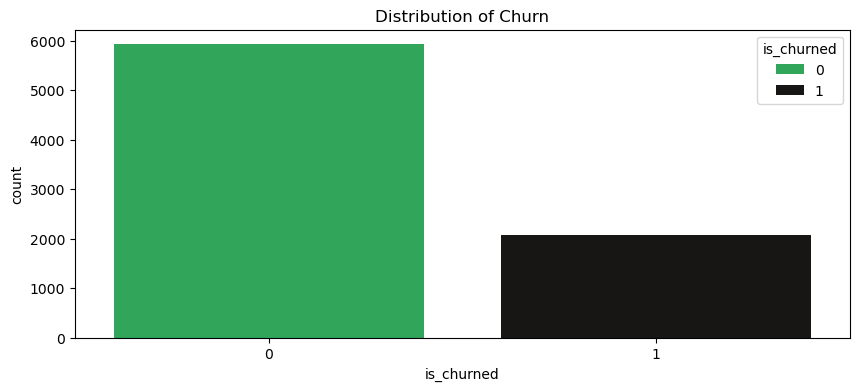

In [6]:
plt.figure(figsize=(10,4))
sns.countplot(x='is_churned', data=churn_df, hue='is_churned', palette=brand_colors)
plt.title('Distribution of Churn')

print(churn_df['is_churned'].value_counts(normalize=True))

Here, we see that there is an imbalance in churn (25.9%) vs no churn (74.1%) so we will keep this in mind when evaluating the prediction model and the rest of the project.

In [7]:
for i in churn_df.columns:
    if churn_df[i].dtype == 'object':
        print(f'{i} - {churn_df[i].nunique()} unique values')

gender - 3 unique values
country - 8 unique values
subscription_type - 4 unique values
device_type - 3 unique values


In [8]:
# one-hot encode categorical variables
churn_df_dum = pd.get_dummies(churn_df, columns=['gender', 'subscription_type', 'device_type'], prefix='is', dtype=int)
churn_df_dum

,user_id,age,country,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,is_Female,is_Male,is_Other,is_Family,is_Free,is_Premium,is_Student,is_Desktop,is_Mobile,is_Web
0,1,54,CA,26,23,0.20,31,0,1,1,0,0,0,1,0,0,1,0,0
1,2,33,DE,141,62,0.34,0,1,0,0,0,1,1,0,0,0,0,0,1
2,3,38,AU,199,38,0.04,0,1,1,0,1,0,0,0,1,0,0,1,0
3,4,22,CA,36,2,0.31,0,1,0,1,0,0,0,0,0,1,0,1,0
4,5,29,US,250,57,0.36,0,1,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,44,DE,237,36,0.30,0,1,1,0,0,1,0,0,0,1,0,1,0
7996,7997,34,AU,61,64,0.59,0,1,0,0,1,0,0,0,1,0,0,1,0
7997,7998,17,US,81,62,0.33,5,0,0,1,0,0,0,1,0,0,1,0,0
7998,7999,34,IN,245,94,0.27,0,1,0,1,0,0,0,0,0,1,1,0,0


In [9]:
# sanity check - ads_listened_per_week > 0 == free account
churn_df_dum[(churn_df_dum['ads_listened_per_week'] > 0) & (churn_df_dum['is_Free'] == 0)]

,user_id,age,country,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,is_Female,is_Male,is_Other,is_Family,is_Free,is_Premium,is_Student,is_Desktop,is_Mobile,is_Web


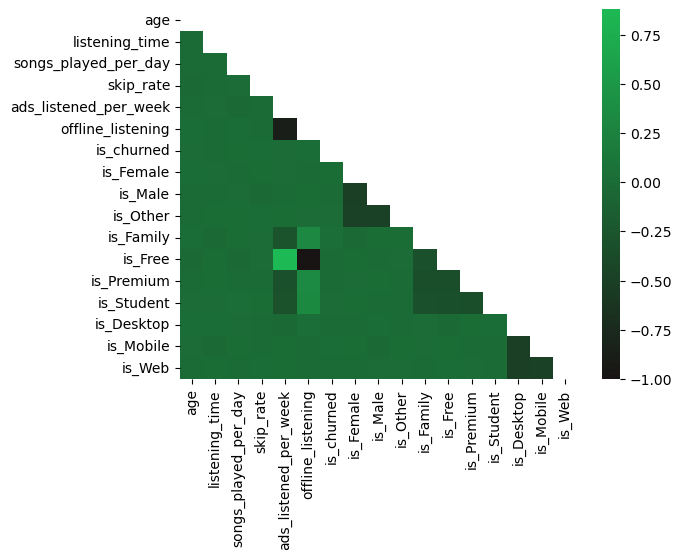

In [10]:
corr = churn_df_dum.drop(columns=['user_id']).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap.reversed())
plt.show()

Most features are uncorrelated (linearly) with the exceptions:
- `ads_listened_per_week` vs `offline_listening` & `is_Free`: higher `offline_listening`, lower number of `ads_listened_per_week` -> which makes sense because `offline_listening` is usually associated with premium subscriptions and ads are associated with free accounts
- Similar reasoning for `ads_listened_per_week` vs `is_Free`

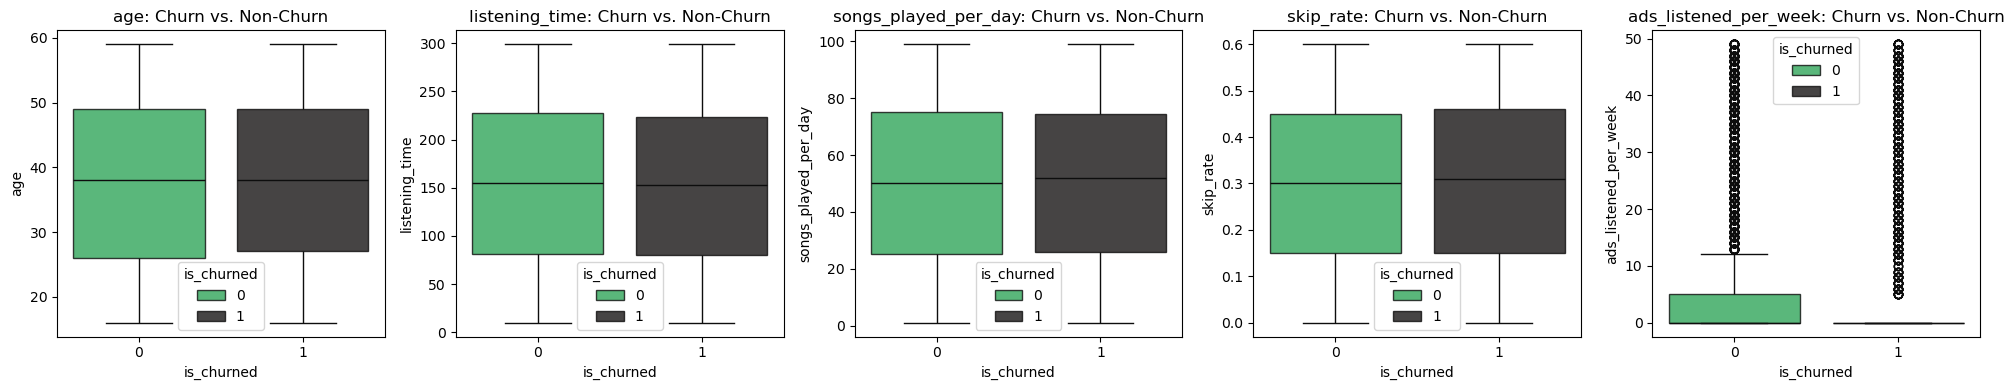

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']):
    sns.boxplot(x='is_churned', y=col, data=churn_df, ax=axes[i], hue='is_churned', palette=brand_colors, boxprops=dict(alpha=0.8))
    axes[i].set_title(f'{col}: Churn vs. Non-Churn')
plt.tight_layout()
plt.show()

The box plots between churned & active (not churned) are relatively comparable across all numerical features (except `ads_listened_per_week`) suggesting that churn is not really driven by a single numerical feature but probably requires multivariate modeling to capture the more subtle patterns.

In [12]:
# scale continuous variables
continuous_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
churn_df_dum[continuous_cols] = StandardScaler().fit_transform(churn_df_dum[continuous_cols])

churn_df_dum

,user_id,age,country,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,is_Female,is_Male,is_Other,is_Family,is_Free,is_Premium,is_Student,is_Desktop,is_Mobile,is_Web
0,1,1.282452,CA,-1.524434,-0.953574,-0.576827,1.766611,0,1,1,0,0,0,1,0,0,1,0,0
1,2,-0.365956,DE,-0.155555,0.417349,0.229702,-0.509938,1,0,0,0,1,1,0,0,0,0,0,1
2,3,0.026522,AU,0.534836,-0.426296,-1.498575,-0.509938,1,1,0,1,0,0,0,1,0,0,1,0
3,4,-1.229408,CA,-1.405401,-1.691763,0.056875,-0.509938,1,0,1,0,0,0,0,0,1,0,1,0
4,5,-0.679939,US,1.141904,0.241590,0.344921,-0.509938,1,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,0.497495,DE,0.987161,-0.496599,-0.000735,-0.509938,1,1,0,0,1,0,0,0,1,0,1,0
7996,7997,-0.287461,AU,-1.107819,0.487653,1.669933,-0.509938,1,0,0,1,0,0,0,1,0,0,1,0
7997,7998,-1.621886,US,-0.869753,0.417349,0.172093,-0.142752,0,0,1,0,0,0,1,0,0,1,0,0
7998,7999,-0.287461,IN,1.082388,1.542209,-0.173562,-0.509938,1,0,1,0,0,0,0,0,1,1,0,0


#### Initial K-Means (Unsupervised Learning)

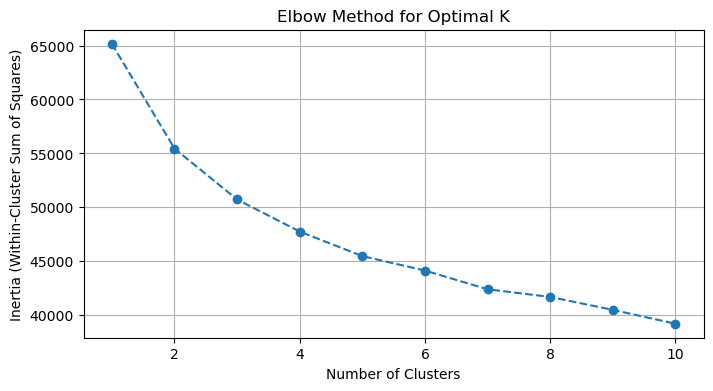

In [13]:
# diving deeper into combinations of variables
churn_df_dum_pca = churn_df_dum.drop(columns=['user_id'])
churn_df_dum_pca = pd.get_dummies(churn_df_dum_pca, columns=['country'], dtype=int)

wcss = []
k_range_wcss = range(1, 11)

for k in k_range_wcss:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(churn_df_dum_pca.drop(columns=['is_churned']))
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range_wcss, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [14]:
sil_scores = []
k_range_sil = range(2, 11) # silhouette requires at least 2 clusters

for k in k_range_sil:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(churn_df_dum_pca.drop(columns=['is_churned']))
    score = silhouette_score(churn_df_dum_pca.drop(columns=['is_churned']), kmeans.labels_)
    sil_scores.append(score)

# find the k with the maximum score
best_k = k_range_sil[np.argmax(sil_scores)]
print(f"Optimal k based on Silhouette Score: {best_k}")

Optimal k based on Silhouette Score: 2


In [15]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(churn_df_dum_pca.drop(columns=['is_churned']))

# add cluster labels to the PCA dataframe
churn_df_dum_pca2 = churn_df_dum_pca.copy()
churn_df_dum_pca2['cluster_kmeans'] = cluster_labels

print(f"K-Means trained with K={2}")
print(churn_df_dum_pca2.groupby('cluster_kmeans')['is_churned'].value_counts(normalize=True))

K-Means trained with K=2
cluster_kmeans  is_churned
0               0             0.749477
                1             0.250523
1               0             0.738502
                1             0.261498
Name: proportion, dtype: float64


With `k=2` we see that the difference in churn rate between the two groups is only about 1%. Since there is very little separation of churn risk between the clusters, the clustering algorithm is struggling to find meaningful boundaries. We use PCA to try to densify the signal.

#### Principal Component Analysis (PCA) + Refined K-Means

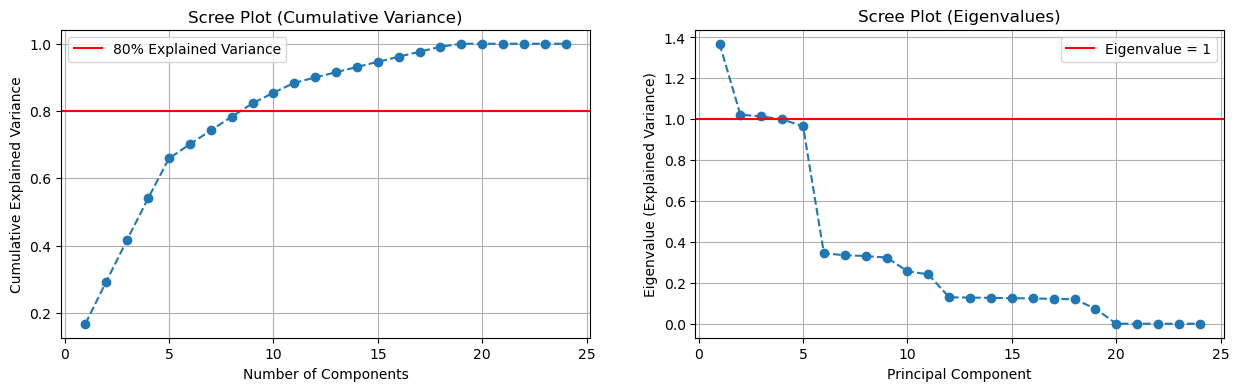

Number of components to explain 80% variance: 9


In [16]:
pca = PCA()
pca.fit(churn_df_dum_pca.drop(columns=['is_churned']))

# calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# scree plot (cumulative variance)
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('Scree Plot (Cumulative Variance)')
axes[0].grid(True)
axes[0].axhline(y=0.80, color='r', linestyle='-', label='80% Explained Variance')
axes[0].legend()

# scree plot (eigenvalues)
eigenvalues = pca.explained_variance_
axes[1].plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Eigenvalue (Explained Variance)')
axes[1].set_title('Scree Plot (Eigenvalues)')
axes[1].grid(True)
axes[1].axhline(y=1, color='r', linestyle='-', label='Eigenvalue = 1')
axes[1].legend()

plt.show()

# Determine number of components for 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to explain 80% variance: {n_components_80}")

Optimal k based on KneeLocator: 4


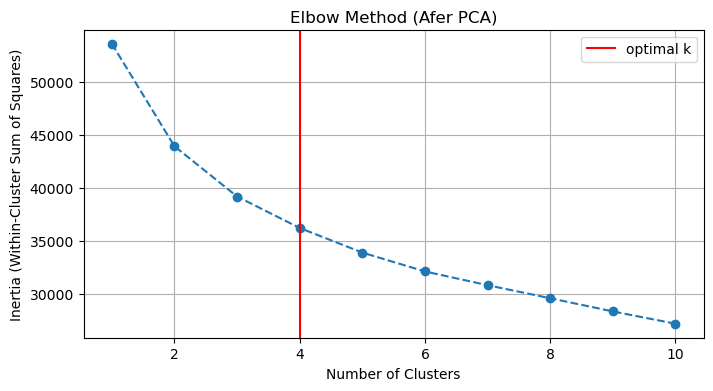

In [17]:
pca_final = PCA(n_components=9)
pca_scores = pca_final.fit_transform(churn_df_dum_pca.drop(columns=['is_churned']))

# find the "elbow" (knee) point
wcss_pca = []

for k in k_range_wcss:
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=50).fit(pca_scores)
    wcss_pca.append(kmeans_pca.inertia_)

# find the "elbow" (knee) point
kn = KneeLocator(k_range_wcss, wcss_pca, curve='convex', direction='decreasing')
print(f"Optimal k based on KneeLocator: {kn.knee}")

plt.figure(figsize=(8, 4))
plt.plot(k_range_wcss, wcss_pca, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.axvline(kn.knee, label=f'optimal k', color='red')
plt.title('Elbow Method (Afer PCA)')
plt.legend()
plt.grid(True)
plt.show()

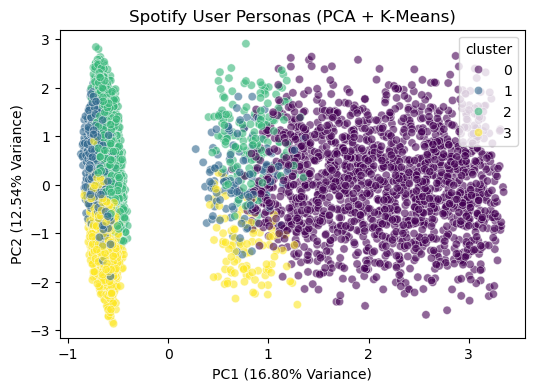

In [18]:
kmeans = KMeans(n_clusters=kn.knee, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(pca_scores)

df_plot = pd.DataFrame(pca_scores[:, :2], columns=['PC1', 'PC2'])
df_plot['cluster'] = cluster_labels
churn_df_dum_pca['cluster'] = cluster_labels

plt.figure(figsize=(6, 4))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_plot, palette='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.title('Spotify User Personas (PCA + K-Means)')
plt.show()

In [19]:
# get loadings for first two components
loadings = pd.DataFrame(
    pca_final.components_.T, 
    columns=[f'PC{i+1}' for i in range(n_components_80)],
    index=churn_df_dum_pca.drop(columns=['is_churned', 'cluster']).columns
)

# look at top contributors for PC1 and PC2
print(f'Top 5 features for PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% Variance):')
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))

print(f'\nTop 5 features for PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% Variance):')
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))

Top 5 features for PC1 (16.80% Variance):
ads_listened_per_week    0.843819
offline_listening        0.347439
is_Free                  0.347439
is_Premium               0.123768
is_Student               0.113674
Name: PC1, dtype: float64

Top 5 features for PC2 (12.54% Variance):
skip_rate               0.701502
age                     0.614702
songs_played_per_day    0.285787
listening_time          0.218292
is_Desktop              0.010626
Name: PC2, dtype: float64


Looking at the top features contributing to PC1 & PC2, we can see that PC1 captures the tier subscription/ad-related features while PC2 captures age/interaction with the platform.

We can therefore choose to represent our axes as:
- PC1: "Pricing Tier Engagement"
- PC2: "Content Satisfaction/Maturity"

We also notice that none of the country features showed up in the top 5, suggesting these findings are more global in nature rather than localized to certain countries.

In [20]:
# look at some of the cluster's features
cluster_profile = churn_df_dum_pca.groupby('cluster').agg({
    'is_churned': 'mean',
    'ads_listened_per_week': 'mean',
    'offline_listening': 'mean',
    'age': 'mean',
    'songs_played_per_day': 'mean',
    'listening_time': 'mean',
    'is_Free': 'mean',
    'skip_rate': 'mean'
})

cluster_profile

,is_churned,ads_listened_per_week,offline_listening,age,songs_played_per_day,listening_time,is_Free,skip_rate
cluster,,,,,,,,
0,0.254579,1.814942,0.000000,-0.038795,-0.030419,-0.001786,1.000000,-0.034569
1,0.274896,-0.465182,0.936203,0.689582,-0.096309,-0.054698,0.063797,0.920924
2,0.261157,-0.464298,0.935950,-1.049420,0.054951,0.113179,0.064050,0.079228
3,0.244290,-0.472891,0.949355,0.632388,0.050908,-0.082179,0.050645,-0.948684


In [21]:
churn_df.groupby(cluster_labels)['age'].mean()

0    37.167888
1    46.447095
2    24.292975
3    45.718471
Name: age, dtype: float64

Here, we see that cluster 1 has the oldest average age of about 46, whereas cluster 2 has the youngest average age of approximately 24.

To ensure the stability of the behavioral segments, the K-Means algorithm was configured with `n_init=50`. This approach helps to mitigate the stochastic nature of centroid initialization. While these clusters reveal distinct usage patterns, the narrow churn variance (24.4%-27.5%) suggests that behavioral 'types' alone are not definitive predictors of churn.

We can observe the behavioral profiles as follows:
- Cluster 0: These are users on the free plan and consequently listen to the most ads.
    - Interestingly, those in this group churn less compared to Cluster 1, possibly suggesting that they have accepted the ads as a "price" for free music (ad-tolerant).
- Cluster 1: These are the most at risk of churning (27.5%). They are also older users who are the on paid tiers thus able to listen offline, but they do not actually spend a lot of time listening (low value-to-price ratio).
    - Even though these users pay for the service, they have the highest churn, but they also listen the least number of songs per day, often skipping songs, possibly suggesting they are not finding much value from the platform.
    - A possible group to target for retention marketing
- Cluster 2: These have the second highest risk of churning (26.1%). They are considerably younger users, but spend the most amount of time listening (out of the 4 clusters), also mostly on the paid tiers.
    - These could be students who are heavy streamers, but more price-sensitive, and hence have a slightly higher than average risk of churning.
- Cluster 3: These have the lowest risk of churning (24.4%). They are generally older listeners. They have the lowest listening time of the 4 clusters even though they are paying for the platform (similar to Cluster 1).
    - They do not skip songs often, suggesting "low maintenance" with an "anything goes" and "put on any playlist" behavior.

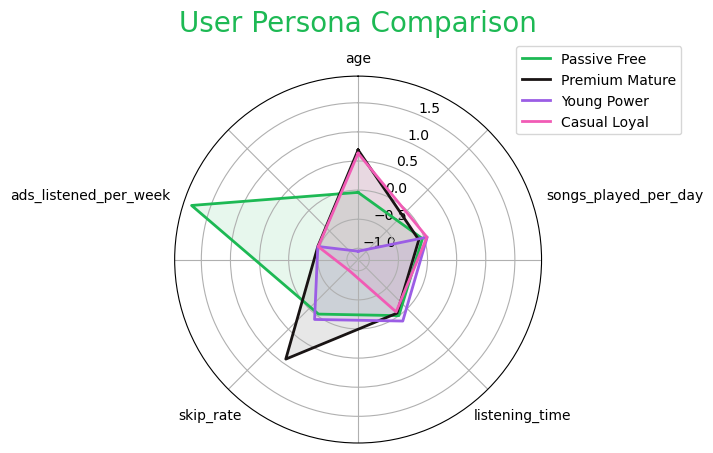

In [22]:
# radar chart for visualization
features = ['age', 'songs_played_per_day', 'listening_time', 'skip_rate', 'ads_listened_per_week']
plot_data = cluster_profile[features]

labels = np.array(features)
num_vars = len(labels)

# compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['#1DB954', '#191414', '#9B5DE5', '#F15BB5']
clusters = ['Passive Free', 'Premium Mature', 'Young Power', 'Casual Loyal']
for i in range(len(plot_data)):
    values = plot_data.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f'{clusters[i]}')
    ax.fill(angles, values, color=colors[i], alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticklabels([])

for i, (angle, label) in enumerate(zip(angles[:-1], labels)):
    ha = 'center'
    if angle > np.pi:
        ha = 'right'
    elif angle > 0:
        ha = 'left'
    
    ax.text(angle, 2.2, label, size=10, horizontalalignment=ha)

plt.title('User Persona Comparison', size=20, color='#1DB954', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
plt.tight_layout()
plt.show()

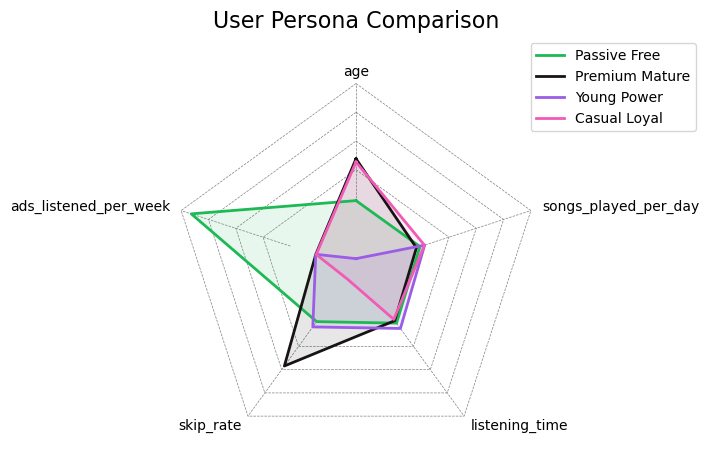

In [23]:
features = ['age', 'songs_played_per_day', 'listening_time', 'skip_rate', 'ads_listened_per_week']
plot_data = cluster_profile[features]
labels = np.array(features)
num_vars = len(labels)

# compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# draw grid
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# hide the default circular grid and spine
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.spines['polar'].set_visible(False)

# draw manual polygonal grid lines
grid_values = [0.5, 1.0, 1.5, 2.0] 
for g in grid_values:
    ax.plot(angles, [g] * len(angles), color='grey', linestyle='--', linewidth=0.5, zorder=1)

# draw the "spokes" (axes lines) from the center to the outer grid
for angle in angles[:-1]:
    ax.plot([angle, angle], [0, max(grid_values)], color='grey', linestyle='--', linewidth=0.5, zorder=1)

# plot data
colors = ['#1DB954', '#191414', '#9B5DE5', '#F15BB5']
clusters = ['Passive Free', 'Premium Mature', 'Young Power', 'Casual Loyal']

for i in range(len(plot_data)):
    values = plot_data.iloc[i].tolist()
    values += values[:1] # Close the loop
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f'{clusters[i]}')
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# add labels
for i, (angle, label) in enumerate(zip(angles[:-1], labels)):
    ha = 'center'
    if angle > np.pi:
        ha = 'right'
    elif angle > 0:
        ha = 'left'
    
    # position labels slightly outside the maximum grid value
    ax.text(angle, max(grid_values) + 0.2, label, size=10, horizontalalignment=ha, verticalalignment='center')

plt.title('User Persona Comparison', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
plt.tight_layout()
plt.show()

#### Random Forest Classifier

In [24]:
X, y = churn_df_dum_pca.drop(columns=['is_churned']), churn_df_dum_pca['is_churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
y_prob_train = rf.predict_proba(X_train)[:, 1]
y_prob_test = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1186
           1       0.32      0.15      0.21       414

    accuracy                           0.70      1600
   macro avg       0.53      0.52      0.51      1600
weighted avg       0.64      0.70      0.65      1600



Since we have moderate class imbalance, the Precision-Recall (PR) curve provides a more realistic view of model performance than AU(ROC). Since the cost of a lost customer likely outweighs the cost of a retention effort, we choose to prioritize **recall** and minimize false negatives, while ensuring precision remains high enough to keep the retention initiatives cost-effective and justifiable.

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
auc_score = roc_auc_score(y_test, y_prob_test)

print(f'F1 Score: {f1_score(y_test, y_pred_test):.2f}')
print(f"ROC-AUC: {auc_score:.2f}")

F1 Score: 0.21
ROC-AUC: 0.53


To ensure the low predictive performance was not a result of poor hyperparameters / model configuration, we used a Randomized Search with 5-fold Cross Validation.

In [26]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    scoring='roc_auc', 
    random_state=42
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Val AUC: {random_search.best_score_}")

Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'class_weight': 'balanced'}
Best Cross-Val AUC: 0.5087164745916939


In [27]:
# we can also look at feature importances of the best hyper-tuned model
best_model = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced', random_state=42)
best_model.fit(X_train, y_train)

pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_ }).sort_values(by='importance', ascending=False).head(5)

,feature,importance
2,songs_played_per_day,0.183717
1,listening_time,0.167240
3,skip_rate,0.127792
0,age,0.119051
4,ads_listened_per_week,0.070397


Initial modeling showed an AUC of 0.53. However, after implementing 5-fold Cross Validation and Randomized Search, the AUC converged to 0.509, indicating that any predictive 'lift' in the initial model was likely due to stochastic noise in the training split. 

While user segments were mathematically distinct (from PCA + K-Means), being clustered into a particular segment is not a deterministic predictor of churn as seen from the low F1 and AUC scores of the classification model, suggesting that the churn outcome is likely triggered by external factors rather than just behavioral patterns alone on the platform.

Additionally, the feature with the highest importance (`songs_played_per_day`) has only 18.3% contribution, followed by 16.7% (`listening_time`), 12.8% (`skip_rate`) and 11.9% (`age`) so the signals of the features were not very strong as predictors to begin with.

Although the behavioral features provided insufficient signal to confidently classify individual churn, the segmentation analysis revealed a churn rate of 27.5% within the 'Premium Mature' cluster. Since we cannot find a pattern to predict churn (at least just using this particular dataset), we can consider a stochastic (probabilistic) process and perform Monte Carlo simulations to quantify the revenue at risk.

#### Monte Carlo Simulation for Cluster 1

We perform Monte Carlo simulation on Cluster 1 to better understand how much fluctuation the business can expect in terms of revenue if these users' concerns are not addressed (leading them to churn), thus helping in financial planning and analysis.

In [28]:
churn_df.subscription_type.unique()

array(['Free', 'Family', 'Premium', 'Student'], dtype=object)

In [29]:
price_map = {'Premium': 11.99, 'Family': 19.99, 'Student': 5.99}

mc_df = churn_df[cluster_labels == 1][['subscription_type', 'is_churned']].copy().reset_index(drop=True)
mc_df['cost'] = mc_df['subscription_type'].map(price_map).fillna(0)
mc_df

,subscription_type,is_churned,cost
0,Premium,0,11.99
1,Premium,0,11.99
2,Family,1,19.99
3,Family,0,19.99
4,Student,0,5.99
...,...,...,...
1923,Student,1,5.99
1924,Family,0,19.99
1925,Student,1,5.99
1926,Premium,0,11.99


In [30]:
# set seed for reproducibility
np.random.seed(42)

churn_prob = mc_df['is_churned'].mean()

n = len(mc_df)
simulations = 10000

churn_matrix = np.random.rand(n, simulations) <= churn_prob

rev_lost = (churn_matrix.T * mc_df['cost'].values).sum(axis=1)

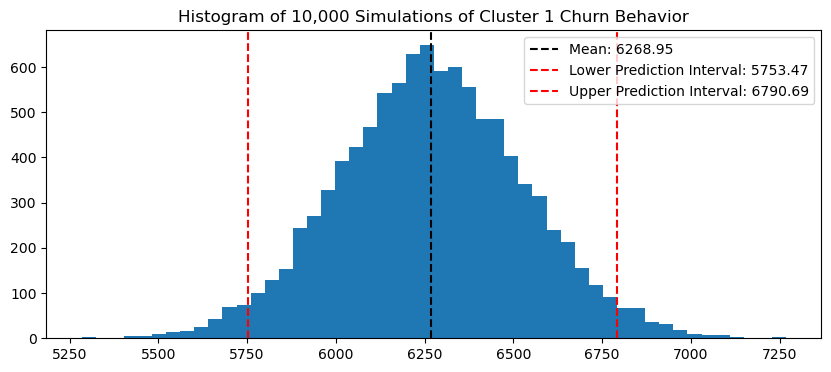

In [31]:
plt.figure(figsize=(10, 4))
# plot revenue lost distribution
plt.hist(rev_lost, bins=50)
# add 95% prediction interval
lower_pi = np.percentile(rev_lost, 2.5)
upper_pi = np.percentile(rev_lost, 97.5)
plt.axvline(rev_lost.mean(), color='k', linestyle='--', label=f'Mean: {rev_lost.mean():.2f}')
plt.axvline(lower_pi, color='r', linestyle='--', label=f'Lower Prediction Interval: {lower_pi:.2f}')
plt.axvline(upper_pi, color='r', linestyle='--', label=f'Upper Prediction Interval: {upper_pi:.2f}')

plt.title('Histogram of 10,000 Simulations of Cluster 1 Churn Behavior')
plt.legend()
plt.show()

To model the potential financial impact of the at risk 'Premium Mature' cluster (Cluster 1) i.e. the stochastic revenue at risk, a Monte Carlo simulation of 10,000 iterations was used by incorporating the specific pricing plan for each user (Premium, Student, Family, Free). This ensures that revenue forecasts account for the inherent randomness in user behavior even when predictive signals (assuming only user behavior data is available) is weak.

For the purpose of this analysis, since this dataset is a snapshot for a subset of customers in 2025, we assume the `is_churned` flag means the user cancelled their subscription within the last billing cycle.

From the results, we can expect a monthly loss of $6,268 with a 95% Prediction Interval of $5,753 to $6,790. This shows us how much variance we can expect (~$1,000 swing) in revenue lost in the next billing cycle, just purely based on random chance. This adds up if we extrapolate it to all Spotify users around the world over all months of the year.

#### Conclusion

**Objective**: 

This project aimed to identify distinct user characteristics within the music streaming ecosystem of Spotify using the 2025 Spotify user data obtained from https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis, with the goal of understanding how usage patterns, demographics and subscription tiers affect with churn risk.

**Methodology**:

- **Data Exploration**: We looked at the balance of classes, distribution of categorical and numerical variables, correlation between numerical/boolean variables
- **Data Segmentation & Classification**: To address high dimensionality and potential multicollinearity. PCA was applied, with 9 components found to capture 80% of the total variance. We then used the K-Means algorithm for unsupervised learning (clustering).
- **Optimization**: Optimal number of clusters (`k=4`) was found using the Elbow/Knee Locator method by minimizing the within-cluster sum of squares (WCSS). Stability was guaranteed through an exhaustive `n_init=50` initialization process.
- **Financial Risk Modeling**: Monte Carlo simulation of 10,000 potential outcomes of churn on Cluster 1 users revealed approximately $6.3k/month of revenue could potentially be lost if these customers were to churn.

**Key Findings**:

The analysis revealed 4 distinct behavioral groups:
- **"Passive Free Users" (Cluster 0)**: High "ad-tolerance", lower churn rate than some paid subscribers but relatively average listening time.
- **"At-Risk Premium Mature" (Cluster 1)**: Older (average age 46), paid-tier subscribers with highest churn rate (27.5%) but low engagement, with high `skip_rate`, indicating a likely "value" gap and possible frustration.
- **"Young Power Users" (Cluster 2)**: High-usage, younger, paid-tier subscribers who have high engagement but are likely price-sensitive, resulting in a higher than average churn rate (26.1%).
- **"Loyal but Casual Users" (Cluster 3)**: Low-usage/engagement but remain paid-tier subscribers. Generally older subscribers. Highest retention / lowest churn rate out of the 4 identified groups. They don't usually skip music, likely just putting on a playlist and letting it play. They're probably users who are "low maintenance" and satisfied with the current system.

**Conclusion**:

While the clusters are relatively behaviorally distinct, the narrow variance in churn rates (ranging from 24.4%-27.5%) suggests that the decision to churn is not purely driven by usage volume or demographic identity, but rather more likely event-driven or externally-triggered.

**Limitations**:

- The current analysis is based on a static snapshot of 2025 data, so we see a user's average behavior but not their behavior over time.
    - Problem: A user may have high "average" listening time, but it may have been dropping in the recent weeks before the snapshot was taken.
    - Without the temporal aspect, K-Means can only group users by who they are at that point in time, and not where they might end up in the coming weeks.
- The dataset only contains (limited) user-platform behavior.
    - Problem: Churn is often caused by factors that the dataset doesn't capture such as competitor behavior e.g. better discounts, platform issues e.g. app crashes, UI updates that a user dislikes, life events e.g. student loses student discount upon graduation.
- Clustering is a "hard clustering" algorithm i.e. every user must belong to exactly one group.
    - In reality, a user might be partly "Passive Free" and partly "Young Power" which could explain the overlaps observed in the PC1 vs PC2 plot. 
    - A soft-clustering algorithm like Gaussian Mixture Models (GMMs) could have handled this better since a user could be grouped into multiple clusters with varying probabilities, but K-Means was chosen for stability and interpretability, allowing for the identification of discrete personas that the business teams can directly act on e.g. via targeted marketing emails.

These limitations do not invalidate the current findings but rather provide a guide for future research and analysis. Incorporating more features e.g. top genres listened to, temporal data could help bridge the gap between these behavioral types and predictive accuracy. Additionally, the current findings also provide a foundation for targeted, segment-specific retention strategies, more specifically for Cluster 1, that retention teams can consider diving deeper into.

#### Possible Business Recommendation
Looking at the "Premium Mature" (Cluster 1) group, they are paying, but they are skipping a lot and listening less, so it is likely that the platform's recommendation system is not working for them. Additionally, skip rates seem to correspond with age (low skip rates -> below 40, high skip rates -> above 40), which could mean the platform's recommendation system is prioritizing music that resonate more with younger audiences. 

Since the average age is 46, these users likely have full-time jobs, more disposable income, perhaps even managers of family plans. If they are frustrated and choose to cancel the entire family plan, it might lead to even higher churn (up to the loss of 6 accounts). If they are listening while commuting, working, etc. and have to constantly skip songs because the music recommendations are not resonating with them, the user experience is not what it could be for them.

We can look into whether the 'Discover picks for you' algorithm is biased towards younger listeners. Two possible intervention points:
- Onboarding: A/B test of new onboarding flow - improve initial preference-profiling of new users over 46 (or generally 40) by providing additional options relevant to specific decades e.g. 80s/90s to kick off the algorithm.
- Day-to-Day: If existing users are already frustrated, it might be more difficult to get them to give the platform another chance before they churn. More intrusive action might be required e.g. improved feedback system through more obvious "Dislike"/"Don't play this artist" buttons, "Reset algorithm" button, automatic algorithm recalibration if a user's skip rate exceeds a certain threshold in a single session.

#### Future Work
If more data becomes available, future iterations of the analysis could look into:
- Incorporating temporal/time-series data to observe a user's listening behavior over time and whether there is a particular pattern associated with churners.
- Competitor actions - whether a user's churn coincides with a competitor lowering their prices / offering more attractive discounts.